## Exportación de resultados en S3

GuardDuty admite la exportación de hallazgos activos a CloudWatch Events y, opcionalmente, a un bucket de Amazon S3. Los nuevos hallazgos activos que se GuardDuty generen se exportan automáticamente unos 5 minutos después de generarse el hallazgo. Puede establecer la frecuencia con la que las actualizaciones de los hallazgos activos se exportan a CloudWatch Eventos. La frecuencia que seleccione se aplica a la exportación de nuevas apariciones de hallazgos existentes a CloudWatch Events, su bucket de S3 (si está configurado) y Detective (si está integrado). Para obtener más información sobre las actualizaciones de los resultados existentes, consulte Agregación de búsquedas de GuardDuty .

In [1]:
import boto3
import json
from botocore.exceptions import ClientError
import pandas as pd
import gzip
import os

In [2]:
# Get the account number
account_number = boto3.client('sts').get_caller_identity().get('Account')
region = 'us-east-1'
# Create the S3 client
s3 = boto3.client('s3')
bucket = "guardduty-export-results-09443"
prefix = f"AWSLogs/{account_number}/GuardDuty/{region}/2024/02/14"

In [3]:
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
files = response['Contents']

In [ ]:
count = 0
# Download all the files
for file in files:
  key = file['Key'] 
  if key.endswith('.jsonl.gz'):
    count += 1
    response = s3.get_object(Bucket=bucket, Key=key)
    key_download = key.split('/')[-1]
    s3.download_file(bucket, key, "logs/" + key_download)
print(f"Downloaded {count} files.")

In [5]:
all_data = []
# Unzip all the files and read the contents
for file in os.listdir("logs/"):
  if file.endswith('.jsonl.gz'):
    with gzip.open("logs/" + file, 'rb') as f:
      file_content = f.read().decode('utf-8').splitlines()
    all_data.append(file_content)

In [6]:
df_inter = pd.DataFrame()
for data in all_data:
  df = pd.DataFrame([json.loads(x) for x in data])
  df_inter = pd.concat([df_inter, df])
df_inter.sort_values(by='severity', ascending=False, inplace=True)
df_inter.reset_index(drop=True, inplace=True)

In [7]:
df_inter.columns

Index(['schemaVersion', 'accountId', 'region', 'partition', 'id', 'arn',
       'type', 'resource', 'service', 'severity', 'createdAt', 'updatedAt',
       'title', 'description'],
      dtype='object')

In [8]:
df_inter.head()

,schemaVersion,accountId,region,partition,id,arn,type,resource,service,severity,createdAt,updatedAt,title,description
0,2.0,655680117358,us-east-1,aws,fac6d3831a6554da8dbc1231fe2e0e61,arn:aws:guardduty:us-east-1:655680117358:detec...,CryptoCurrency:EC2/BitcoinTool.B!DNS,"{'resourceType': 'Instance', 'instanceDetails'...","{'serviceName': 'guardduty', 'detectorId': '8e...",8,2024-02-14T09:50:18.314Z,2024-02-14T12:10:24.763Z,The EC2 instance i-0b5c23d5710ea37d8 queried a...,The EC2 instance i-0b5c23d5710ea37d8 is queryi...
1,2.0,655680117358,us-east-1,aws,a2c6d3831ac49a7da469202dab2fb336,arn:aws:guardduty:us-east-1:655680117358:detec...,Backdoor:EC2/C&CActivity.B!DNS,"{'resourceType': 'Instance', 'instanceDetails'...","{'serviceName': 'guardduty', 'detectorId': '8e...",8,2024-02-14T09:50:18.505Z,2024-02-14T13:55:22.886Z,The EC2 instance i-0b5c23d5710ea37d8 queried a...,The EC2 instance i-0b5c23d5710ea37d8 is queryi...
2,2.0,655680117358,us-east-1,aws,fac6d3831a6554da8dbc1231fe2e0e61,arn:aws:guardduty:us-east-1:655680117358:detec...,CryptoCurrency:EC2/BitcoinTool.B!DNS,"{'resourceType': 'Instance', 'instanceDetails'...","{'serviceName': 'guardduty', 'detectorId': '8e...",8,2024-02-14T09:50:18.314Z,2024-02-14T18:25:25.208Z,The EC2 instance i-0b5c23d5710ea37d8 queried a...,The EC2 instance i-0b5c23d5710ea37d8 is queryi...
3,2.0,655680117358,us-east-1,aws,a2c6d3831ac49a7da469202dab2fb336,arn:aws:guardduty:us-east-1:655680117358:detec...,Backdoor:EC2/C&CActivity.B!DNS,"{'resourceType': 'Instance', 'instanceDetails'...","{'serviceName': 'guardduty', 'detectorId': '8e...",8,2024-02-14T09:50:18.505Z,2024-02-14T12:25:22.717Z,The EC2 instance i-0b5c23d5710ea37d8 queried a...,The EC2 instance i-0b5c23d5710ea37d8 is queryi...
4,2.0,655680117358,us-east-1,aws,82c6d386aa454a5ab75656331890b229,arn:aws:guardduty:us-east-1:655680117358:detec...,Trojan:EC2/DNSDataExfiltration,"{'resourceType': 'Instance', 'instanceDetails'...","{'serviceName': 'guardduty', 'detectorId': '8e...",8,2024-02-14T09:58:05.194Z,2024-02-14T16:58:18.415Z,Data exfiltration through DNS queries from the...,The EC2 instance i-0b5c23d5710ea37d8 is attemp...


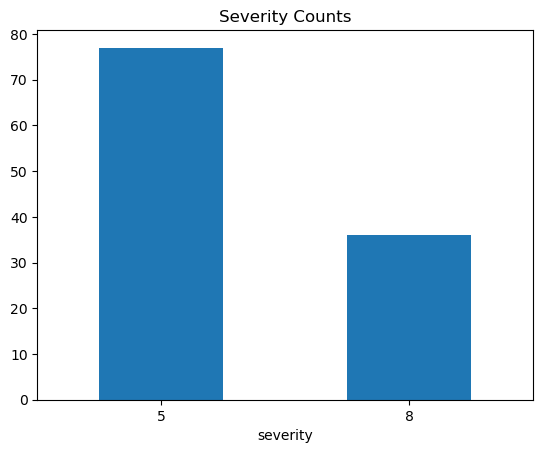

In [22]:
# Horizontal bar plot
df_inter.value_counts('severity').plot(kind='bar', title='Severity Counts', rot=0);

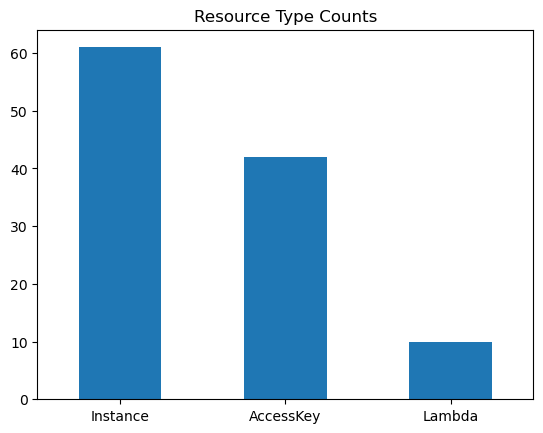

In [23]:
df_inter['resource_specifc'] = df_inter['resource'].apply(lambda x: x['resourceType'] if 'resourceType' in x else 'None')
df_inter.value_counts('resource_specifc').plot(kind='bar', title='Resource Type Counts', rot=0, xlabel='');